Big Data And Society: Problem Set 3 (Part B)
=====


# APIs and Data Scraping: Getting Twitter Data

### 1. Importing the Libraries and Twitter Keys

We will be using **Twython**, a Python library that provides wrappers around Twitter's API. To install **Twython** on a terminal or the command line, run the following command:

```
pip install twython
```

We also need to import the keys we just got from Twitter to be accessible to our code. View the contents of **twitter_key.py** to see your keys. These should both be strings.

```
# In the file you should define two variables:
api_key = "your twitter key"
api_secret = "your twitter secret"
```

Import the libraries:



In [1]:
# Import libraries
import json
import time
import threading
from datetime import datetime
from twython import Twython

# Imports the keys from the python file
from twitter_key import api_key, api_secret

### 2. Set Up Twython, Get an OAuth2 Token, and Create your Twython Object

In this next step, assign the keys to variables and set up our instance of Twython to work with your account.

Doing this requires our authentication with Twitter using our keys. Twitter uses something called [OAuth](https://dev.twitter.com/oauth) for API authentication. There are two types of OAuth authentication. OAuth1 provides user authentication to the API, and is required to post tweets and issue requests on behalf of users. OAuth 2 is [application-only authentication](https://dev.twitter.com/oauth/application-only), and has higher rate limits but doesn't allow you to post on users behalf. Because we can get more tweets using it, we are going to use OAuth2. 

**OAuth 2 requires a Third Access token you must request using the API. This next step will set everything up for us.**

In the last part of this, we create a **Twython** object and call it **my_twython**; this object simplifies the access to the [Twitter API](https://dev.twitter.com/overview/documentation), and provides methods for accessing the API‚Äôs endpoints. The first function fetches tweets with a given query at a given lat-long. We will be using the search parameters to hit the APIs endpoint. We need to provide the lat/lon of the centroid of the area we want to query, maximum number of tweets to return, and area within the centroid to search for, among others.

In [3]:
# Assigns the keys to the variables
APP_KEY = api_key
APP_SECRET = api_secret

# Create a Twython object called Twitter
# Set this up using your Twitter Keys
# Say we are going to use OAuth 2
twython_setup = Twython(APP_KEY, APP_SECRET, oauth_version=2)

# Get an OAuth2 access token, save as variable so we can launch our 
OAUTH2_ACCESS_TOKEN = twython_setup.obtain_access_token()

# Create a Twython Object we will use for our access to the API
my_twython = Twython(APP_KEY, access_token=OAUTH2_ACCESS_TOKEN)

For reference, the Twython documentation and all available commands can be found here. [https://twython.readthedocs.io/en/latest/usage/starting_out.html](https://twython.readthedocs.io/en/latest/usage/starting_out.html)

### 3. Query the Twitter API to get Tweets at a Location

Next, let's do a search and get some tweets! Specifically, set up a function that will use the **search** API. Read more about the **search** API [here](https://dev.twitter.com/rest/reference/get/search/tweets).

The **Search API** can take many parameters for querying tweets. Twitter has a nice page of what you can use as query parameters here [https://dev.twitter.com/rest/public/search](https://dev.twitter.com/rest/public/search).

The Twitter API has rate limits that limit how quickly you can download data. This is to try to lighten the load on their servers. We are using the Search API with **OAuth2 (Application) Access** - which limits us to **450 in 15 minutes** Read about the [Rate Limits](https://dev.twitter.com/rest/public/rate-limiting) here. This means, in our following steps, always follow the guideline that you will not be able to get more than 450 tweets in 15 minutes, or Twitter might lock your access.

In [4]:
# Input the search term you want to search on
search_term='MIT' # SET A SEARCH TERM
# Setup a Lat Lon
latlong=[42.361145,-71.057083] # Boston, MA
# Setup a search distance
distance='25mi'
# Set result type (can be 'recent', 'popular', or 'mixed')
type_of_result='recent'
# Set number of results (up to 100, remember you can only get 450 in 15 minutes)
number_of_tweets=70


# Fetches tweets with a given query at a given lat-long.
def get_tweets_by_location( latlong=None ):
    # Uses the search function to hit the APIs endpoints and look for recent tweets within the area
    results = my_twython.search(q=search_term, geocode=str(latlong[0])+','+str(latlong[1])+','+ distance, result_type=type_of_result, count=number_of_tweets)
    # Returns only the statuses from the resulting JSON
    return results['statuses']

# test run our function
get_tweets_by_location(latlong)

[{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Mar 03 19:47:36 +0000 2017',
  'entities': {'hashtags': [],
   'symbols': [],
   'urls': [{'display_url': 'twitter.com/i/web/status/8‚Ä¶',
     'expanded_url': 'https://twitter.com/i/web/status/837751328411697154',
     'indices': [117, 140],
     'url': 'https://t.co/yPiCwJxTjf'}],
   'user_mentions': []},
  'favorite_count': 0,
  'favorited': False,
  'geo': None,
  'id': 837751328411697154,
  'id_str': '837751328411697154',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'metadata': {'iso_language_code': 'en', 'result_type': 'recent'},
  'place': None,
  'possibly_sensitive': False,
  'retweet_count': 0,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
  'text': "Mr. Adams, Jake F

### 4. Automate it - Hit the API and Parse the Result

We are going to create a function to help us repeatedly hit the API, and parse the result into a readable JSON that contains the things that we are interested in, and still stores the raw tweet as an additional property. The returned object is a Python `dict` that we can easily parse into another dictionary to later store as a JSON. Raw JSONs returned from the API have a specific structure.

It can be sometimes hard to read a raw JSON. I find it easy to use some online parsers like [this]( http://jsonparseronline.com/) to look at the structure of the JSON, and only access what we care about.

Note: Remember we are limited to 450 every 15 minutes.

In [5]:
# Does pretty much what its long name suggests.
def get_lots_of_tweets( latlong ):
    # Create a dictionary to parse the JSON
    all_tweets = {}
    
    # We will be hitting the API a number of times within the total time
    total_time =900
    
    # Everytime we hit the API we subtract time from the total
    remaining_seconds = total_time
    interval = 150
    while remaining_seconds > 0: # loop and run the function while remaining seconds is greater than zero
        added = 0
        # Hit the Twitter API using our function
        new_tweets = get_tweets_by_location(latlong) # we set latlong above!
        # Parse the resulting JSON, and save the rest of the raw content
        for tweet in new_tweets:
            tid = tweet['id']
            if tid not in all_tweets:
                properties = {}
                if tweet['coordinates'] != None:
                    properties['lat'] = tweet['coordinates']['coordinates'][0]
                    properties['lon'] = tweet['coordinates']['coordinates'][1]
                else:
                    properties['lat'] = None
                    properties['lon'] = None
                properties['location'] = tweet['user']['location'] #This will get us the location associated with the profile
                properties['tweet_id'] = tid
                properties['content'] = tweet['text']
                properties['user'] = tweet['user']['id']
                properties['raw_source'] = tweet
                properties['data_point'] = 'none'
                properties['time'] = tweet['created_at']
                all_tweets[ tid ] = properties
                added += 1
        print("At %d seconds, added %d new tweets, for a total of %d" % ( total_time - remaining_seconds, added, len( all_tweets )))
        # We wait a few seconds and hit the API again
        time.sleep(interval)
        remaining_seconds -= interval
    print(str(len(all_tweets)) + ' Tweets retrieved.')
    # We return the final dictionary to work with in Python
    return all_tweets

### 5. Run the Twitter Scraper

We need to call the functions, and save the JSONs into a location. In this case, I made a folder called **data**, where I am saving all the new JSONS. We can run the code continuously utilizing some loop, or we can use libraries like [threading](https://docs.python.org/3.6/library/threading.html).

*Make sure you have a folder named **data** in the directory with your notebook! This function will save our collected datafiles to it when it finishes running.*

In [20]:
# This function executes the functions over a given period of time
def run_all():
    # This is the number of times the code will be executed. In this case, just once. 
    starting = 1
    while starting > 0:
        # Sometimes the API returns some errors, killing the whole script, so we setup try/except to make sure it keeps running
        try:
            t = get_lots_of_tweets( latlong )
            # We name every file with the current time
            timestr = time.strftime("%Y%m%d-%H%M%S")
            # We write a new JSON into the target path
            with open( 'dataB/' + '%stweets.json' %(timestr), 'w' ) as f:
                f.write(json.dumps(t))
            # we can use a library like threading to execute the run function continuously.
            #threading.Timer(10, run).start()
            starting -= 1
        except:
            pass
    
run_all()

At 0 seconds, added 70 new tweets, for a total of 70
At 150 seconds, added 1 new tweets, for a total of 71
At 300 seconds, added 4 new tweets, for a total of 75
At 450 seconds, added 1 new tweets, for a total of 76
At 600 seconds, added 3 new tweets, for a total of 79
At 750 seconds, added 2 new tweets, for a total of 81
81 Tweets retrieved.


### 6. Let's Explore the Data we Saved to our Machine

Let's look through the JSON we created and checkout some of the data we just downloaded. First, let's import a couple of additional libraries that will let us interact with our file system, use numpy and pandas, and create plots:

In [6]:
# Import some additional libraries that will allow us to plot and interact with the operating system
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Next, let's explore our data a bit. This following function will allow us to perform a visual examination of what we downloaded from Twitter. Once we have collected some data, we can parse it, and visualize some of the results. Since some of the data is repeated, we can initialize some lists to check whether or not a tweet already exists, and add it to the list. We can then extract the useful information for our purposes, and store it in another list.

Building on last week, we can do this in Pandas.

In [7]:
# Get the file names from a given directory
file_dir = "dataB" # Set this to where your JSON saved
# Get only the JSONs we have saved
onlyfiles = [ f for f in listdir(file_dir) if isfile(join(file_dir,f)) and not f.startswith('.')]

# create an empty dataframe with columns for each property
df_tweets = pd.DataFrame(columns = ['tweet_id', 'lat', 'lon', 'content','location','user','raw_source','data_point','time'])

# Loop through all the files
for file in onlyfiles:
    full_dir = join(file_dir,file) 
    with open(full_dir) as json_data:
        dict = json.load(json_data) # creates a Python dictionary of our json
        if not isinstance(dict, list):
            for key, val in dict.items():
                df_tweets.loc[key,val] = val
                
df_tweets.head()

tweet_id   lat   lon  \
837147354797072384  837147354797072384  None  None   
837145795707166722  837145795707166722  None  None   
837144208657936384  837144208657936384  None  None   
837143631786041344  837143631786041344  None  None   
837143617600962560  837143617600962560  None  None   

                                                              content  \
837147354797072384  RT @MITSloan: Does your religion inform your l...   
837145795707166722  RT @MIT: Lego approved the @LegoNASAWomen set ...   
837144208657936384  RT @MITSloan: Does your religion inform your l...   
837143631786041344  RT @mitsmr: Wow. The share of organizations re...   
837143617600962560  RT @MITSloan: Does your religion inform your l...   

                                   location        user  \
837147354797072384                      USA   121306396   
837145795707166722                NYC Metro  1418692928   
837144208657936384                             49562338   
837143631786041344               Montevideo    24363198   
837143617600962560  Gatineau/Ottawa, Canada  1117103910   

                                                           raw_source  \
837147354797072384  {'created_at': 'Thu Mar 02 03:47:37 +0000 2017...   
837145795707166722  {'created_at': 'Thu Mar 02 03:41:25 +0000 2017...   
837144208657936384  {'created_at': 'Thu Mar 02 03:35:07 +0000 2017...   
837143631786041344  {'created_at': 'Thu Mar 02 03:32:49 +0000 2017...   
837143617600962560  {'created_at': 'Thu Mar 02 03:32:46 +0000 2017...   

                   data_point                            time  
837147354797072384       none  Thu Mar 02 03:47:37 +0000 2017  
837145795707166722       none  Thu Mar 02 03:41:25 +0000 2017  
837144208657936384       none  Thu Mar 02 03:35:07 +0000 2017  
837143631786041344       none  Thu Mar 02 03:32:49 +0000 2017  
837143617600962560       none  Thu Mar 02 03:32:46 +0000 2017

### 7. Summarize, Group, and Plot the Dataset

Next let's summarize and group our data, and create some plots.

**A** - First, group by the user location. This is not lat/lon, but rather the information the individual has input on their profile.

When you give people the power to input their own location, you get an assortment of 'creative' responses!

In [8]:
df_tweets.dtypes

tweet_id      object
lat           object
lon           object
content       object
location      object
user          object
raw_source    object
data_point    object
time          object
dtype: object

In [9]:
df_tweets['location'].unique()

array(['USA', 'NYC Metro', '', 'Montevideo', 'Gatineau/Ottawa, Canada',
       'Cambridge MA', 'Cambridge, MA', 'Deer Park, TX', 'Pluto',
       'Ottawa, Ontario', 'Quad Cities, USA ', 'Boston', 'The Netherlands',
       'Savannah, GA', 'Kentucky, USA', 'Lima,Peru', 'New York, NY',
       'London ', 'Cambridge, MA, USA', 'Norwood, MA', 'Ann Arbor, MI',
       'Rio, S√£o Paulo, The World.', 'The Void', 'planet Earth ',
       'Bogot√° Island D.C.', 'Birmingham, AL', 'Brooklyn, NY',
       'Denver, CO', 'Stankonia', 'Boston, MA USA', 'Chicago, IL',
       'California, USA', 'ATL ', 'Boston, Massachusetts',
       'Boston, MA, USA', 'Shanghai', 'Bloodstream', 'Alpha Quadrant',
       'Brookline, Massachusetts, USA', 'Atlanta, GA', 'Halfmoon, NY',
       'Southern Maine USA', 'Mumbai', 'Williamsburg, Virginia',
       'Johannesburg', 'Cambridge, Massachusetts, U.S.', 'Wuppertal',
       'North Carolina, US', 'Tampa, FL', 'Minneapolis, MN', 'Boston, MA',
       'Bluffton, SC', 'NYC', 'South

Now let's do some grouping and sorting. We are using Pandas to do our analysis, much like last week.

In [10]:
#grouping and sorting using Pandas
grouped_tweets = df_tweets.groupby('location')
count_tweets = grouped_tweets['location'].count()
df_count_tweets = count_tweets.to_frame()
df_count_tweets.columns = ['Count']
df_count_tweets.index.names = ['Location']
df_count_tweets.sort_index()

Count
Location                             
                                   17
ATL                                 1
Alpha Quadrant                      1
Ann Arbor, MI                       1
Atlanta, GA                         1
Birmingham, AL                      1
Bloodstream                         1
Bluffton, SC                        1
Bogot√° Island D.C.                  1
Boston                              2
Boston, MA                          2
Boston, MA USA                      1
Boston, MA, USA                     1
Boston, Massachusetts               1
Brookline, Massachusetts, USA       1
Brooklyn, NY                        2
California, USA                     1
Cambridge MA                        1
Cambridge, MA                       7
Cambridge, MA, USA                  2
Cambridge, Massachusetts, U.S.      1
Chicago, IL                         1
Deer Park, TX                       1
Denver, CO                          1
Flint, MI                           1
Gatineau/Ottawa, Canada             1
Halfmoon, NY                        1
Johannesburg                        1
Kentucky, USA                       1
Lima,Peru                           1
London                              1
Minneapolis, MN                     1
Montevideo                          1
Mumbai                              1
NYC                                 1
NYC Metro                           1
New York, NY                        1
North Carolina, US                  1
Norwood, MA                         1
Ottawa, Ontario                     1
Pluto                               1
Quad Cities, USA                    1
Rio, S√£o Paulo, The World.          1
Savannah, GA                        1
Shanghai                            1
Southeastern Pennsylvania           1
Southern Maine USA                  1
Stankonia                           1
Tampa, FL                           1
The Netherlands                     1
The Void                            1
USA                                 1
Williamsburg, Virginia              1
Wuppertal                           1
planet Earth                        1

In [18]:
#Cleaning the data
# List of variations of Locations

variations_of_Boston = ['Boston','Boston, MA','Boston, MA USA','Boston, MA, USA','Boston, Massachusetts','rgv // boston']
df_tweets2 = df_tweets.replace(variations_of_Boston, 'Boston')
variations_of_Cambridge = ['Cambridge MA','Cambridge, MA','Cambridge, MA, USA','Cambridge,MA','Cambridge, Massachusetts, U.S.']
df_tweets3 = df_tweets2.replace(variations_of_Cambridge, 'Cambridge')
variations_of_New_York = ['New York, NY','NYC','NYC Metro','NYC √¢‚Ç¨¬¢ BOS √¢‚Ç¨¬¢ SFO √¢‚Ç¨¬¢ LON']
df_tweets4 = df_tweets3.replace(variations_of_New_York, 'New York')
variations_of_Latin_America = ['Rio, S√£o Paulo, The World.','S√£o Paulo Paulo, Brasil','Bogot√° Island D.C.','Lima,Peru',
                               'Venezuela','Chile','Plano Piloto de Bras√≠lia','Montevideo']
df_tweets5 = df_tweets4.replace(variations_of_Latin_America, 'Latin America')
variations_of_Non_sense = ['Alpha Quadrant','Citizen of the World√Ç¬Æ','Pluto','Quad Cities, USA ','The Void','World','planet Earth ',
                           'Stankonia','Bloodstream']
df_tweets6 = df_tweets5.replace(variations_of_Non_sense, 'Imagined places')
variations_of_other_MA = ['Andover, MA','Brookline, Massachusetts, USA','Westborough, MA','Norwood, MA']
df_tweets7 = df_tweets6.replace(variations_of_other_MA, 'other MA')
variations_of_other_USA = ['Ann Arbor, MI','Arizona State University','Birmingham, AL','Bluffton, SC','Brooklyn, NY','California, USA',
                          'Chicago, IL','Deer Park, TX','Denver, CO','Encinitas, CA','Flint, MI','Gatineau/Ottawa, Canada',
                         'Halfmoon, NY','Irvine, California','Kentucky, USA','Minneapolis, MN','Newark','North Carolina, US',
                         'Oklahoma, USA','Ottawa, Ontario','Phoenix, Arizona USA','Raleigh, NC','Savannah, GA','ATL ','Atlanta, GA',
                          'Southeastern Pennsylvania','Southern Maine USA','Tampa, FL','USA','Washington, DC','Williamsburg, Virginia']
df_tweets8 = df_tweets7.replace(variations_of_other_USA, 'other USA and Canada')
variations_of_Europe = ['Brussels, Belgium','Johannesburg','London','The Netherlands ','Wuppertal','The Netherlands',
                       'The Netherlands','London ','Johannesburg','Wuppertal', 'The Netherlands', 'London ','Shanghai', 'Mumbai']
df_tweets9 = df_tweets8.replace(variations_of_Europe, 'Europe')
variations_of_Asia = ['Mumbai','New Delhi , India','London','Newcastle, NSW Australia','Shanghai','Shanghai','Sydney']
df_tweets10 = df_tweets9.replace(variations_of_Asia, 'Asia-Pacific')
variations_of_empty = [" ",'']
df_tweets11 = df_tweets9.replace(variations_of_empty, 'No data')

df_tweets11

tweet_id   lat   lon  \
837147354797072384  837147354797072384  None  None   
837145795707166722  837145795707166722  None  None   
837144208657936384  837144208657936384  None  None   
837143631786041344  837143631786041344  None  None   
837143617600962560  837143617600962560  None  None   
837143019551862784  837143019551862784  None  None   
837142862781370369  837142862781370369  None  None   
837142417610584064  837142417610584064  None  None   
837142320101273600  837142320101273600  None  None   
837142104086282240  837142104086282240  None  None   
837140584645214208  837140584645214208  None  None   
837140346404470785  837140346404470785  None  None   
837139764038012929  837139764038012929  None  None   
837139328228720640  837139328228720640  None  None   
837138804330938369  837138804330938369  None  None   
837138627612327937  837138627612327937  None  None   
837138190045708288  837138190045708288  None  None   
837138074966585344  837138074966585344  None  None   
837137814122811392  837137814122811392  None  None   
837137111375568896  837137111375568896  None  None   
837136848262676483  837136848262676483  None  None   
837136763206303744  837136763206303744  None  None   
837136669841162240  837136669841162240  None  None   
837136618129670144  837136618129670144  None  None   
837135381367664640  837135381367664640  None  None   
837135052253323268  837135052253323268  None  None   
837134631686254593  837134631686254593  None  None   
837134608915292160  837134608915292160  None  None   
837133890376646657  837133890376646657  None  None   
837133061884153859  837133061884153859  None  None   
...                                ...   ...   ...   
837124904591962113  837124904591962113  None  None   
837123639044616196  837123639044616196  None  None   
837123576415256576  837123576415256576  None  None   
837123522640105472  837123522640105472  None  None   
837123416507486208  837123416507486208  None  None   
837122497871036416  837122497871036416  None  None   
837122082467168258  837122082467168258  None  None   
837122026066296833  837122026066296833  None  None   
837121976024117249  837121976024117249  None  None   
837121781513269249  837121781513269249  None  None   
837121578634706944  837121578634706944  None  None   
837121393745620993  837121393745620993  None  None   
837120613798068224  837120613798068224  None  None   
837118903583145986  837118903583145986  None  None   
837118576515514368  837118576515514368  None  None   
837118111337840646  837118111337840646  None  None   
837117949932625920  837117949932625920  None  None   
837117283591942145  837117283591942145  None  None   
837116374338125824  837116374338125824  None  None   
837148208010784768  837148208010784768  None  None   
837149216430522368  837149216430522368  None  None   
837149012650262528  837149012650262528  None  None   
837148748274860032  837148748274860032  None  None   
837148736002326528  837148736002326528  None  None   
837149764802203648  837149764802203648  None  None   
837150387824177152  837150387824177152  None  None   
837150229677776896  837150229677776896  None  None   
837150188158476292  837150188158476292  None  None   
837151010904805380  837151010904805380  None  None   
837150901672505344  837150901672505344  None  None   

                                                              content  \
837147354797072384  RT @MITSloan: Does your religion inform your l...   
837145795707166722  RT @MIT: Lego approved the @LegoNASAWomen set ...   
837144208657936384  RT @MITSloan: Does your religion inform your l...   
837143631786041344  RT @mitsmr: Wow. The share of organizations re...   
837143617600962560  RT @MITSloan: Does your religion inform your l...   
837143019551862784  Last book I read was Machine Learning. Next up...   
837142862781370369  Played around with @MIT's "diversity dashboard...   
837142417610584064  Does your religion inform your leadership styl...   
837142320101273600  RT @

In [19]:
#test after cleaning the data
df_tweets11['location'].unique()

array(['other USA and Canada', 'New York', 'No data', 'Latin America',
       'Cambridge', 'Imagined places', 'Boston', 'Europe', 'other MA'], dtype=object)

In [20]:
#new grouping and sorting after cleaning
grouped_tweets2 = df_tweets11.groupby('location')
count_tweets2 = grouped_tweets2['location'].count()
df_count_tweets2 = count_tweets2.to_frame()
df_count_tweets2.columns = ['Count']
df_count_tweets2.index.names = ['Location']
df_count_tweets2.sort_index()

Count
Location                   
Boston                    7
Cambridge                11
Europe                    6
Imagined places           7
Latin America             4
New York                  3
No data                  17
other MA                  2
other USA and Canada     24

Let's create a pie chart of these using matplotlib.

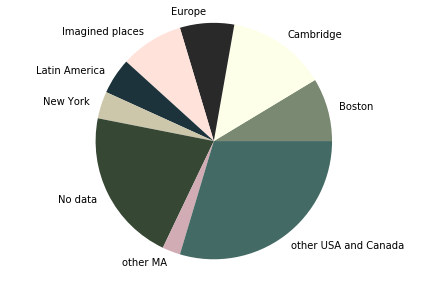

In [21]:
# Create a list of colors (from iWantHue)
colors = ["#7a8972",
"#fdffe8",
"#2a2929",
"#ffe3db",
"#1c333c",
"#ccc7ab",
"#364734",
"#d1acb4",
"#446a65",
"#b19785",
"#564d4f",
"#93bec4",
"#684f41",
"#6d979c"]

# Create a pie chart
plt.pie( df_count_tweets2['Count'], labels=df_count_tweets2.index.get_values(), shadow=False, colors=colors)

# View the plot drop above
plt.axis('equal')

# View the plot
plt.tight_layout()
plt.show()

**B** - Next, let's find how many actually have a location and put them on a scatterplot. To do this, we need to find first the rows where lat and long are not None, and then create the plot from just that subset of the data. Let's give it a go.

In [22]:
# Create a filter from df_tweets filtering only those that have values for lat and lon
df_tweets_with_location = df_tweets[df_tweets.lon.notnull() & df_tweets.lat.notnull()]
df_tweets_with_location

Empty DataFrame
Columns: [tweet_id, lat, lon, content, location, user, raw_source, data_point, time]
Index: []

In [24]:
This would be the code for the scatterplot, but I am not getting any tweet with latitude and longitude,
therefore I can not plot it.
# Use a scatter plot to make a quick visualization of the data points
# THERE ARE none IN 81 TWEETS!
#plt.scatter(df_tweets_with_location['lon'],df_tweets_with_location['lat'], s=25)
#plt.show()

### 8. Remove duplicates


**Remove Duplicates** - Make sure that we don't get tweets plotted more than once. How would you make sure to only plot unique tweets? We can maybe use [drop_duplicates](http://chrisalbon.com/python/pandas_delete_duplicates.html)

In [25]:
#convert to strings
df_tweets10 = df_tweets.astype(str)

In [26]:
#identify duplicates
df_tweets10.duplicated()

837147354797072384    False
837145795707166722    False
837144208657936384    False
837143631786041344    False
837143617600962560    False
837143019551862784    False
837142862781370369    False
837142417610584064    False
837142320101273600    False
837142104086282240    False
837140584645214208    False
837140346404470785    False
837139764038012929    False
837139328228720640    False
837138804330938369    False
837138627612327937    False
837138190045708288    False
837138074966585344    False
837137814122811392    False
837137111375568896    False
837136848262676483    False
837136763206303744    False
837136669841162240    False
837136618129670144    False
837135381367664640    False
837135052253323268    False
837134631686254593    False
837134608915292160    False
837133890376646657    False
837133061884153859    False
                      ...  
837124904591962113    False
837123639044616196    False
837123576415256576    False
837123522640105472    False
837123416507486208  

In [27]:
#remove duplicates
df_tweets10.drop_duplicates()

tweet_id   lat   lon  \
837147354797072384  837147354797072384  None  None   
837145795707166722  837145795707166722  None  None   
837144208657936384  837144208657936384  None  None   
837143631786041344  837143631786041344  None  None   
837143617600962560  837143617600962560  None  None   
837143019551862784  837143019551862784  None  None   
837142862781370369  837142862781370369  None  None   
837142417610584064  837142417610584064  None  None   
837142320101273600  837142320101273600  None  None   
837142104086282240  837142104086282240  None  None   
837140584645214208  837140584645214208  None  None   
837140346404470785  837140346404470785  None  None   
837139764038012929  837139764038012929  None  None   
837139328228720640  837139328228720640  None  None   
837138804330938369  837138804330938369  None  None   
837138627612327937  837138627612327937  None  None   
837138190045708288  837138190045708288  None  None   
837138074966585344  837138074966585344  None  None   
837137814122811392  837137814122811392  None  None   
837137111375568896  837137111375568896  None  None   
837136848262676483  837136848262676483  None  None   
837136763206303744  837136763206303744  None  None   
837136669841162240  837136669841162240  None  None   
837136618129670144  837136618129670144  None  None   
837135381367664640  837135381367664640  None  None   
837135052253323268  837135052253323268  None  None   
837134631686254593  837134631686254593  None  None   
837134608915292160  837134608915292160  None  None   
837133890376646657  837133890376646657  None  None   
837133061884153859  837133061884153859  None  None   
...                                ...   ...   ...   
837124904591962113  837124904591962113  None  None   
837123639044616196  837123639044616196  None  None   
837123576415256576  837123576415256576  None  None   
837123522640105472  837123522640105472  None  None   
837123416507486208  837123416507486208  None  None   
837122497871036416  837122497871036416  None  None   
837122082467168258  837122082467168258  None  None   
837122026066296833  837122026066296833  None  None   
837121976024117249  837121976024117249  None  None   
837121781513269249  837121781513269249  None  None   
837121578634706944  837121578634706944  None  None   
837121393745620993  837121393745620993  None  None   
837120613798068224  837120613798068224  None  None   
837118903583145986  837118903583145986  None  None   
837118576515514368  837118576515514368  None  None   
837118111337840646  837118111337840646  None  None   
837117949932625920  837117949932625920  None  None   
837117283591942145  837117283591942145  None  None   
837116374338125824  837116374338125824  None  None   
837148208010784768  837148208010784768  None  None   
837149216430522368  837149216430522368  None  None   
837149012650262528  837149012650262528  None  None   
837148748274860032  837148748274860032  None  None   
837148736002326528  837148736002326528  None  None   
837149764802203648  837149764802203648  None  None   
837150387824177152  837150387824177152  None  None   
837150229677776896  837150229677776896  None  None   
837150188158476292  837150188158476292  None  None   
837151010904805380  837151010904805380  None  None   
837150901672505344  837150901672505344  None  None   

                                                              content  \
837147354797072384  RT @MITSloan: Does your religion inform your l...   
837145795707166722  RT @MIT: Lego approved the @LegoNASAWomen set ...   
837144208657936384  RT @MITSloan: Does your religion inform your l...   
837143631786041344  RT @mitsmr: Wow. The share of organizations re...   
837143617600962560  RT @MITSloan: Does your religion inform your l...   
837143019551862784  Last book I read was Machine Learning. Next up...   
837142862781370369  Played around with @MIT's "diversity dashboard...   
837142417610584064  Does your religion inform your leadership styl...   
837142320101273600  RT @

### 9. Exporting your Data to CSV

Exporting your dataset is easy, you can use **to_csv()**. This [Stack Exchange](http://stackoverflow.com/questions/16923281/pandas-writing-dataframe-to-csv-file) page will help you.

In [28]:
df_tweets10.to_csv('twitter_data_Boston_MIT_clean.csv', sep=',', encoding='utf-8')